### A. Setups

In [81]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import pandas as pd

import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = "sans-serif"
%matplotlib inline

In [39]:
MFST = pd.read_csv('MSFT.csv')
MFST.Date = pd.to_datetime(MFST.Date, dayfirst=False)

IntRate = pd.read_csv('1-year-gov bond.csv')
IntRate.Date = pd.to_datetime(IntRate.Date, dayfirst=True)

In [40]:
print(MFST.info())
MFST

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    251 non-null    datetime64[ns]
 1   Close   251 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB
None


,Date,Close
0,2025-05-14,452.91
1,2025-05-13,449.14
2,2025-05-12,449.26
3,2025-05-09,438.73
4,2025-05-08,438.17
...,...,...
246,2024-05-20,425.34
247,2024-05-17,420.21
248,2024-05-16,420.99
249,2024-05-15,423.08


### B. LSM

In [82]:
def GeneratePaths_Antithetic(nTraj, nStep, T, r, sigma, S0):
    """
    Note: Return a 2D ndarray of the shape 2*NbTraj * (NbStep+1)
    """
    dt = T/nStep
    dW = np.sqrt(dt) * np.random.randn(nTraj, nStep)
    dW = np.vstack((dW, -dW)); nTraj = nTraj*2

    dlnS = (r-(sigma**2)/2)*dt + sigma*dW
    lnS0 = np.log(S0) * np.ones((nTraj, 1))
    lnPaths = np.cumsum(np.hstack((lnS0, dlnS)), axis=1)
    Paths = np.exp(lnPaths)
    return Paths

def element_wise_max(x,y):
    """
    x, y are 1D ndarrays of the same length.
    Note: Return a 1D ndarray of the same length as x and y.
    """
    mat = np.vstack((x,y))
    return np.max(mat, axis=0)

def BasisFunc_Config(S):
    """
    Note:
    S is a 1D ndarray.
    Return the matrix X for regression.
    X is a 2D ndarray.
    """
    Const = np.ones(len(S))
    Basis1 = S
    Basis2 = S**2
    Basis3 = S**3
    X = np.vstack((Const, Basis1,Basis2,Basis3)).T
    return X

class LeastSquare:
    """
    X is a DataFrame.
    y is a Series.
    Output is 
    """
    def __init__(self, BasisFunc_Config, S, y):
        X = BasisFunc_Config(S)
        model = LinearRegression(fit_intercept=False)
        model.fit(X, y)
        self.coefs = model.coef_
        self.fitted = model.predict(X)

def EurPut(SBegin, Strike, T, sigma, r):
    """
    Note:
    r is the annualized continuos risk-free rate.
    sigma is the volatility of stock return per period.
    """
    d1 = (np.log(SBegin/Strike) + (r + 0.5*(sigma**2)) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = Strike * np.exp(-r * T) * norm.cdf(-d2) - SBegin * norm.cdf(-d1)
    return put_price


    
    
def LSM_Put(SBegin, Strike, T, sigma, r, nStep, nTraj):
    """
    Normalizing method to avoid numerical issue: divide prices and payoffs by the initial price
    Note1: Half of nTraj trajectories are simulated using antithetic method

    Note2:
    r is the annualized continuos risk-free rate.
    nStep is the total time intervals over T.

    Note3: This function return a dictionary of insample result and outsample result.
    """
    S0=1; K=Strike/SBegin
    
    dt=T/nStep
    DiscountFactor = np.exp(-r*T/nStep)

    #In-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    Coef = np.array([np.nan] * nStep, dtype=object)
    
    for t in range(nStep, 0, -1): #t = nStep -> 1
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]
        
        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            regression = LeastSquare(BasisFunc_Config, St[ITM], Realized_PayOff[ITM])
            EPV_PayOff = regression.fitted
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]
            Coef[t] = regression.coefs
        
    InSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin
    
    
    #Out-of-sample Values
    S = GeneratePaths_Antithetic(int(nTraj/2),nStep,T,r,sigma,S0)
    
    for t in range(nStep, 0, -1):
        St = S[:,t]
        PayOff = element_wise_max(np.zeros(nTraj), K - St)
        ITM = np.array(range(nTraj))[PayOff > 0]

        if t == nStep:
            Realized_PayOff = PayOff
        else:
            Realized_PayOff = Realized_PayOff * DiscountFactor
            EPV_PayOff = BasisFunc_Config(St[ITM]) @ Coef[t]
            Exercise = PayOff[ITM] > EPV_PayOff
            Realized_PayOff[ITM[Exercise]] = PayOff[ITM[Exercise]]

    OutSample_Realized_PayOff = Realized_PayOff * DiscountFactor * SBegin

    
    res = {"InSample":np.mean(InSample_Realized_PayOff), "OutSample":np.mean(OutSample_Realized_PayOff)}
    return res


print(EurPut(SBegin=452.91, Strike=1350, T=1, sigma=0.2547, r=0.0203))
LSM_Put(SBegin=452.91, Strike=455, T=15/250, sigma = 0.2547, r=0.0203, nStep=50, nTraj=50000)["InSample"]

869.9618323568519


np.float64(12.078591578867519)

### C. Estimating volatility $\sigma$ and risk-free rate $r$

### D. Convergence test

In [60]:
nPaths_range = np.arange(1, 51) * 2000
Insamples = np.array([np.nan] * len(nPaths_range))
Outsamples = np.array([np.nan] * len(nPaths_range))

for i, nTraj in enumerate(nPaths_range):
    SBegin=452.91; Strike=460; T=15/250; sigma=0.2889; r=0.0203; nStep=50
    
    res = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)
    Insamples[i], Outsamples[i] = res["InSample"], res["OutSample"]

In [61]:
print(Insamples)
print(Outsamples)

[16.86202404 16.93067271 16.652439   16.6016756  16.45196587 16.56425712
 16.45686348 16.3923382  16.40989756 16.56962058 16.39150261 16.36143065
 16.50266882 16.39328015 16.37206974 16.57385424 16.46697954 16.50981785
 16.4468955  16.41283059 16.5154295  16.36463943 16.42448769 16.44223002
 16.44327305 16.45138733 16.45323953 16.46180607 16.46842675 16.39768123
 16.44330711 16.45288607 16.46894582 16.43048407 16.4399     16.42073525
 16.40723831 16.37728461 16.36649045 16.47917689 16.45595728 16.4600494
 16.40520569 16.42844879 16.42051048 16.45291282 16.45807669 16.42936761
 16.49624106 16.43239554]
[16.11157224 16.23097322 16.17082437 16.463276   16.4450989  16.42773346
 16.57156952 16.43093708 16.41576403 16.4524591  16.41677625 16.4359318
 16.33316257 16.33557385 16.39477744 16.40381832 16.53229953 16.38334128
 16.43972838 16.39700113 16.38259672 16.39084186 16.36912573 16.41397427
 16.3764428  16.38054731 16.43913527 16.44502869 16.37395965 16.32811104
 16.3588573  16.42088727 16

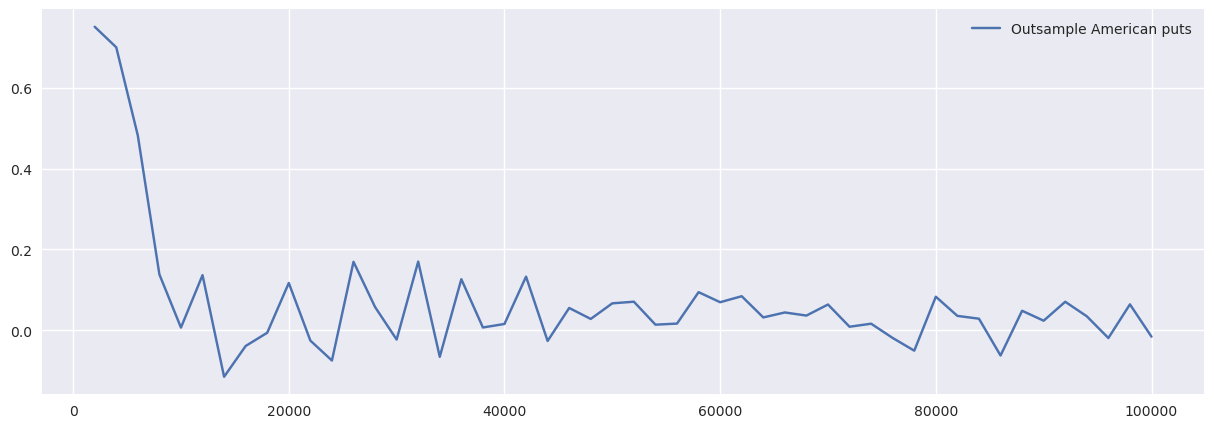

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
#ax.plot(nPaths_range, Insamples, label="Insample American puts")
ax.plot(nPaths_range, Insamples - Outsamples, label="Outsample American puts")
ax.legend()

plt.show(); plt.close()

### E. Estimated results

<span style="color:blue"> __LSM Amer put vs Black-Scholes Eur put at different strike prices__ </span>

In [65]:
Strike_range = np.linspace(start=455, stop=500, num=100)
Eur_vals = np.array([np.nan] * len(Strike_range))
Amer_vals = np.array([np.nan] * len(Strike_range))

for i, Strike in enumerate(Strike_range):
    SBegin=452.91; T=1; sigma=0.1342; r=0.0203; nStep=50; nTraj=10000
    
    Eur_vals[i] = EurPut(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r)
    Amer_vals[i] = LSM_Put(SBegin=SBegin, Strike=Strike, T=T, sigma=sigma, r=r, nStep=nStep, nTraj=nTraj)["InSample"]

In [66]:
print(Eur_vals)
print(Amer_vals)

[20.67837414 20.89288408 21.10871427 21.32586377 21.54433159 21.76411665
 21.98521778 22.20763379 22.43136336 22.65640516 22.88275775 23.11041964
 23.33938926 23.56966499 23.80124512 24.0341279  24.2683115  24.50379402
 24.7405735  24.97864791 25.21801518 25.45867314 25.70061959 25.94385225
 26.18836877 26.43416676 26.68124376 26.92959724 27.17922463 27.43012329
 27.68229051 27.93572355 28.19041959 28.44637575 28.70358912 28.96205671
 29.22177549 29.48274236 29.74495418 30.00840775 30.27309983 30.53902711
 30.80618624 31.07457381 31.34418638 31.61502044 31.88707244 32.16033878
 32.43481582 32.71049986 32.98738716 33.26547395 33.54475639 33.82523061
 34.10689269 34.38973869 34.67376459 34.95896636 35.24533991 35.53288112
 35.82158584 36.11144986 36.40246895 36.69463883 36.98795518 37.28241367
 37.57800992 37.8747395  38.17259796 38.47158083 38.77168358 39.07290167
 39.37523052 39.67866553 39.98320205 40.28883541 40.59556093 40.90337387
 41.21226948 41.522243   41.83328961 42.14540449 42

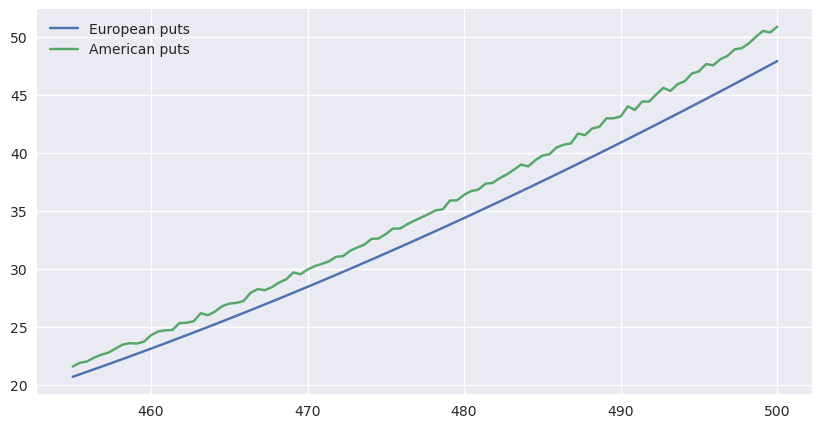

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(Strike_range, Eur_vals, label="European puts")
ax.plot(Strike_range, Amer_vals , label="American puts")
ax.legend()
plt.show(); plt.close()

<span style="color:blue"> __Observed values vs LSM values of ITM Amer put on May 14th 2025__ </span>

In [78]:
K = np.array([np.nan] * 9); oVal = np.array([np.nan] * 9)
K[0] = 455; oVal[0] = 5.69
K[1] = 457.5; oVal[1] = 7.6
K[2] = 460; oVal[2] = 9.75
K[3] = 465; oVal[3] = 14.28
K[4] = 470; oVal[4] = 19.2
K[5] = 472.5; oVal[5] = 21.52
K[6] = 485; oVal[6] = 34.2
K[7] = 495; oVal[7] = 44.4
K[8] = 500; oVal[8] = 49
Sig = np.linspace(start=0.05, stop=1, num=100)

In [79]:
Sig

array([0.05      , 0.05959596, 0.06919192, 0.07878788, 0.08838384,
       0.0979798 , 0.10757576, 0.11717172, 0.12676768, 0.13636364,
       0.1459596 , 0.15555556, 0.16515152, 0.17474747, 0.18434343,
       0.19393939, 0.20353535, 0.21313131, 0.22272727, 0.23232323,
       0.24191919, 0.25151515, 0.26111111, 0.27070707, 0.28030303,
       0.28989899, 0.29949495, 0.30909091, 0.31868687, 0.32828283,
       0.33787879, 0.34747475, 0.35707071, 0.36666667, 0.37626263,
       0.38585859, 0.39545455, 0.40505051, 0.41464646, 0.42424242,
       0.43383838, 0.44343434, 0.4530303 , 0.46262626, 0.47222222,
       0.48181818, 0.49141414, 0.5010101 , 0.51060606, 0.52020202,
       0.52979798, 0.53939394, 0.5489899 , 0.55858586, 0.56818182,
       0.57777778, 0.58737374, 0.5969697 , 0.60656566, 0.61616162,
       0.62575758, 0.63535354, 0.64494949, 0.65454545, 0.66414141,
       0.67373737, 0.68333333, 0.69292929, 0.70252525, 0.71212121,
       0.72171717, 0.73131313, 0.74090909, 0.75050505, 0.76010

In [72]:
SBegin=452.91; T=15/250; nStep=50; nTraj=10000
nK = 9; nSig=len(Sig)

x = np.array([0.0] * nK * nSig)
y = np.array([0.0] * nK * nSig)
z = np.array([0.0] * nK * nSig)

cnt = -1
for i in range(0, nK):
    for j in range(0, nSig):
        cnt = int(cnt+1)
        Strike = K[i]
        x[cnt] = Sig[j]; sigma = x[cnt]
        y[cnt] = LSM_Put(SBegin, Strike, T, sigma, r, nStep, nTraj)["InSample"]
        z[cnt] = Strike

In [73]:
df = pd.DataFrame({"Sigma":x, "Val":y, "Strike":z})
df[df.Sigma == Sig[1]]

,Sigma,Val,Strike
1,0.059596,3.555774,455.0
101,0.059596,5.287652,457.5
201,0.059596,7.295566,460.0
301,0.059596,12.106141,465.0
401,0.059596,17.083552,470.0
501,0.059596,19.594782,472.5
601,0.059596,32.078329,485.0
701,0.059596,42.078778,495.0
801,0.059596,47.078975,500.0


/tmp/ipykernel_43257/3699668152.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


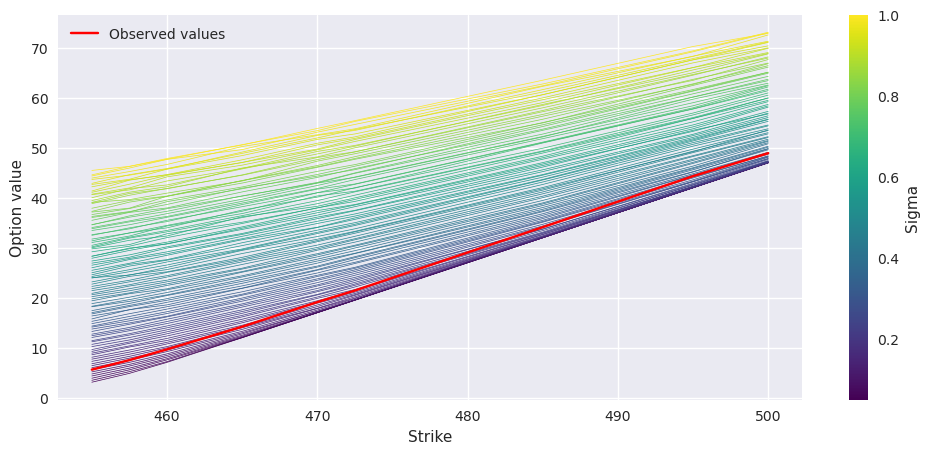

In [77]:
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize


cmap = get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.
norm = Normalize(vmin=min(Sig), vmax=max(Sig))


fig, ax = plt.subplots(figsize=(12,5))
for sig in Sig:
    color = cmap(norm(sig))
    frame = df[df.Sigma == sig]
    ax.plot(frame.Strike, frame.Val, color=color, linewidth=0.5)

ax.plot(K, oVal, color="r", label="Observed values")
ax.legend()
ax.set_xlabel("Strike")
ax.set_ylabel("Option value")


#Show color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Sigma')

plt.show(); plt.close()